In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:
import claude.utils as cu
import claude.tx as tx
import claude.claudeflow.systems as cfs
import claude.claudeflow.training as cft
import claude.claudeflow.helper as cfh
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.models.SSFstatic as ssf

In [3]:
# True:  runs on cluster with GPU etc
# False: can run localy
runWithNonlinear = False

See [`tf_wdmSystem-learning.html`](tf_wdmSystem-learning.html) for version with `runWithNonlinear = True`

In [4]:
if runWithNonlinear:  
    # load memory_saving_gradients.py
    # see https://github.com/cybertronai/gradient-checkpointing
    import urllib.request
    memSavingGradientsFilename = "memory_saving_gradients.py"
    if not os.path.exists(memSavingGradientsFilename):
        memSavingGradientsURL = "https://raw.githubusercontent.com/cybertronai/gradient-checkpointing/master/memory_saving_gradients.py"
        urllib.request.urlretrieve(memSavingGradientsURL, memSavingGradientsFilename)

        import memory_saving_gradients
        tf.__dict__["gradients"] = memory_saving_gradients.gradients_collection

In [5]:
# Tx
param = cfs.defaultParameters(precision='double')

if runWithNonlinear:    
    param.sps = 16
    param.nSamples = 1024
    param.optimizeP = False
    param.PdBm  = 1
else:    
    param.sps = 16
    param.nSamples = 1024
    param.PdBm  = -2 # linear regime such there is no nonlinear interference
    
param.M     = 64
param.Fs    = param.sps * param.Rs
param.nPilots = 128
param.pilotOrder = 4
print(param)

M:	64
nPol:	2
sps:	16
nSamples:	1024
rollOff:	0.05
filterSpan:	128
optimizeP:	False
PdBm:	-2
Rs:	32000000000.0
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
frequencyShift:	True
dispersionCompensation:	False
beta2:	2.0999953937404486e-26
dz:	1000000.0
Fs:	512000000000.0
N:	16384
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>
nPilots:	128
pilotOrder:	4



In [6]:
ssfParam = ssf.defaultParameters(precision='double')
ssfParam.Fs = param.Fs
ssfParam.N = param.sps * (param.nSamples+param.nPilots)
ssfParam.noiseEnabled = True
ssfParam.noiseFigure = 5
ssfParam.nSpans = 10

if runWithNonlinear:
    ssfParam.gamma = 1.3
    ssfParam.nSteps = 350
else:
    ssfParam.gamma = 0
    ssfParam.nSteps = 2

# ssfParam.stepSize = ssfParam.spanLength/ssfParam.nSteps
# ssfParam.stepSizeTemplate = ssfParam.stepSize * np.ones((ssfParam.nSteps,)) # constant stepsize

ssfParam.stepSizeTemplate = ssf.logStepSizes(ssfParam.spanLength, ssfParam.alpha, ssfParam.nSteps) # log stepsize

print(ssfParam)

Fs:	512000000000.0
N:	18432
nSteps:	2
stepSize:	100
ampScheme:	EDFA
noiseEnabled:	True
manakovEnabled:	True
dispersionCompensationEnabled:	False
checkpointInverval:	2
nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	2.0999953937404486e-26
gamma:	0
nSpans:	10
spanLength:	100
noiseFigure:	5
intType:	<dtype: 'int32'>
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>
stepSizeTemplate:	[ 7.52466421 92.47533579]



In [7]:
aeParam = cu.AttrDict()
aeParam.seed    = 1337
aeParam.constellationOrder = param.M
aeParam.constellationDim = 2

if runWithNonlinear:
    aeParam.nLayers = 4
    aeParam.nHidden = 64
else:
    aeParam.nLayers = 2
    aeParam.nHidden = 32

aeParam.activation = tf.nn.relu

print(aeParam)

seed:	1337
constellationOrder:	64
constellationDim:	2
nLayers:	2
nHidden:	32
activation:	<function relu at 0x7f03ce2d0e18>



In [8]:
trainingParam = cu.AttrDict()
if runWithNonlinear:    
    trainingParam.batchSize     = 1
    trainingParam.nBatches      = 2
    trainingParam.nMiniBatches  = 4
    trainingParam.evalBatches   = 10
    trainingParam.removeSymbols = 32
    trainingParam.learningRate  = 0.0005
else:    
    trainingParam.batchSize     = 1
    trainingParam.nBatches      = 2
    trainingParam.nMiniBatches  = 4
    trainingParam.evalBatches   = 5
    trainingParam.removeSymbols = 32
    trainingParam.learningRate  = 0.005
    
trainingParam.nEpochs             = 100

trainingParam.displayStep         = 5
trainingParam.path                = 'results_SSFM'
trainingParam.filename            = 'M{:03d}_seed{:04d}'.format(param.M,aeParam.seed)
trainingParam.earlyStopping       = 10
trainingParam.earlyStoppingMetric = 'xentropy'
trainingParam.summaries           = True

# generalize this
if trainingParam.summaries:
    # tensorboard directory
    hyperParam = ['M']
    aeHyperParam = ['seed']
    trainingHyperParam = ['learningRate']

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,param[item]) for item in hyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

    print(trainingParam.summaryString,flush=True)
    
print(trainingParam)

M=64,learningRate=0.005,seed=1337
batchSize:	1
nBatches:	2
nMiniBatches:	4
evalBatches:	5
removeSymbols:	32
learningRate:	0.005
nEpochs:	100
displayStep:	5
path:	results_SSFM
filename:	M064_seed1337
earlyStopping:	10
earlyStoppingMetric:	xentropy
summaries:	True
summaryString:	M=64,learningRate=0.005,seed=1337



In [9]:
# Constants
c = 299792458
tf.set_random_seed(aeParam.seed)
np.random.seed(aeParam.seed)

In [10]:
X = tf.placeholder(param.realType, shape=(None, param.nChannels, param.nPol, param.nSamples, param.M))
txSymbols, constellation = ae.encoder(X, aeParam, toComplex=True)

W1013 15:36:30.858669 139655415179072 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# pilot symbols
X_pilot = tf.placeholder(param.realType, shape=(None, param.nChannels, param.nPol, param.nPilots, param.pilotOrder))
pilot_constellation = tx.qammod(param.pilotOrder)
pilot_constellation_tf = tf.constant(pilot_constellation, param.complexType)
pilot_txSymbols = cfh.QAMencoder(X_pilot, pilot_constellation_tf, realOutput=False)

In [12]:
txSymbols = tf.concat([pilot_txSymbols,txSymbols], axis=-1)

In [13]:
txSymbols

<tf.Tensor 'concat:0' shape=(?, 5, 2, 1152) dtype=complex128>

In [14]:
param.nSamples = param.nSamples + param.nPilots
signal = cfs.wdmTransmitter(txSymbols, param)

In [15]:
ssfParam.dispersionCompensationEnabled = False
ssfParam.stepSize = tf.placeholder(param.realType, shape=(ssfParam.nSpans, ssfParam.nSteps))
signalOut = ssf.model(ssfParam, signal)

param.dispersionCompensation = True
param.beta2  = ssfParam.D * 1e-6 * ( c / ssfParam.Fc )**2 / ( 2 * np.pi * c )
param.dz     = ssfParam.spanLength * 1e3 * ssfParam.nSpans
rxSymbols = cfs.wdmReceiver(signalOut, param)

nSpans: 10, nSteps: 2


In [16]:
P0 = tf.get_default_graph().get_tensor_by_name("P0:0")
PdBm = tf.get_default_graph().get_tensor_by_name("PdBm:0")
normP0 = tf.get_default_graph().get_tensor_by_name("normP0:0")
rxSymbols = tf.cast( tf.rsqrt( normP0 ), param.complexType ) * rxSymbols

In [17]:
# simulate static phase rotation 
if not runWithNonlinear:
    rxSymbols = rxSymbols * tf.exp(1j * 0.5)

In [18]:
rxSymbols = cfh.staticPhaseRotationCompensation(rxSymbols, nPilots=param.nPilots)
rxSymbols = cfh.testPhases(pilot_constellation_tf, txSymbols, rxSymbols, 4, param.pilotOrder, nTestPhases=4, nPilots=param.nPilots)

In [19]:
txSymbols = txSymbols[..., param.nPilots:]
rxSymbols = rxSymbols[..., param.nPilots:]

In [20]:
rxSymbols, txSymbols, labels = cfh.truncate(trainingParam.removeSymbols, rxSymbols, txSymbols, tf.linalg.matrix_transpose(X))
labels = tf.linalg.matrix_transpose(labels)

decoder = ae.decoder( rxSymbols, aeParam, fromComplex=True)
softmax = tf.nn.softmax(decoder)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=decoder))

In [21]:
nDims = 4 # Dimension of X
reduce_axis = [0, 2, 3]
errorrate = cfh.symbolErrorrate(constellation, txSymbols, rxSymbols, nDims, param.M, reduce_axis)

one = tf.constant( 1, P0.dtype )
effSNR = cfh.effectiveSNR(txSymbols, rxSymbols, one, reduce_axis)

# gaussMI
gaussMI = []
for (txChannel, rxChannel) in zip(tf.split(txSymbols, param.nChannels, axis=1), tf.split(rxSymbols, param.nChannels, axis=1)):
    gaussMI_temp = cfh.gaussianMI(tf.reshape(txChannel,[-1]), tf.reshape(rxChannel,[-1]), constellation, param.M)
    gaussMI.append(gaussMI_temp)
gaussMI = tf.stack(gaussMI)

# nnMI
Px = tf.constant( 1/param.M, param.realType )
nnMI = []
for (sm, l) in zip(tf.split(softmax, param.nChannels, axis=1), tf.split(labels, param.nChannels, axis=1)):
    nnMI_temp = cfh.softmaxMI(sm, l, Px)
    nnMI.append(nnMI_temp)
nnMI = tf.stack(nnMI)

# only gaussMId channel
gaussMIdChannel = param.nChannels//2 +1
errorrate = errorrate[gaussMIdChannel]
gaussMI = gaussMI[gaussMIdChannel]
effSNR = effSNR[gaussMIdChannel]

In [22]:
metricsDict = {'xentropy':loss, 'errorrate':errorrate, 'gaussMI': gaussMI, 'nnMI': nnMI, 'effSNR': effSNR}

In [23]:
def feedDictFun(trainingParam):
    randomisedStepSize = ssf.randomizeSteps(ssfParam.stepSizeTemplate, ssfParam.spanLength, ssfParam.nSpans)
    x, idx, x_seed = cu.hotOnes((trainingParam.batchSize, param.nChannels, param.nPol, param.nSamples-param.nPilots), (1,2,3,4,0),param.M)
    x_pilot, _, _  = cu.hotOnes((trainingParam.batchSize, param.nChannels, param.nPol, param.nPilots), (1,2,3,4,0),param.pilotOrder)
    return { X:x, X_pilot:x_pilot, ssfParam.stepSize:randomisedStepSize }

In [24]:
sess = tf.compat.v1.Session()
sess, outMetrics = cft.train(sess, tf.train.AdamOptimizer, loss, metricsDict, trainingParam, feedDictFun, debug=False)

W1013 15:36:49.354468 139655415179072 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1013 15:36:49.505682 139655415179072 deprecation.py:323] From /home/rasmus/PhD/claudeOnline/claude/claude/claudeflow/training.py:26: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W1013 15:36:58.000062 139655415179072 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: ad

epoch: 0005 - xentropy: 3.9725 - errorrate: 0.4042 - gaussMI: 4.5424 - nnMI: 0.2689 - effSNR: 16.8626
epoch: 0010 - xentropy: 3.6043 - errorrate: 0.3795 - gaussMI: 4.6195 - nnMI: 0.8001 - effSNR: 16.8560
epoch: 0015 - xentropy: 3.1596 - errorrate: 0.3921 - gaussMI: 4.6193 - nnMI: 1.4416 - effSNR: 16.8553
epoch: 0020 - xentropy: 2.7683 - errorrate: 0.3669 - gaussMI: 4.7443 - nnMI: 2.0062 - effSNR: 16.8670
epoch: 0025 - xentropy: 2.4229 - errorrate: 0.3503 - gaussMI: 4.8132 - nnMI: 2.5045 - effSNR: 16.8213
epoch: 0030 - xentropy: 2.1527 - errorrate: 0.3242 - gaussMI: 4.9014 - nnMI: 2.8943 - effSNR: 16.8529
epoch: 0035 - xentropy: 1.9142 - errorrate: 0.3015 - gaussMI: 4.9906 - nnMI: 3.2385 - effSNR: 16.7981
epoch: 0040 - xentropy: 1.6991 - errorrate: 0.2789 - gaussMI: 5.0432 - nnMI: 3.5487 - effSNR: 16.8793
epoch: 0045 - xentropy: 1.4928 - errorrate: 0.2758 - gaussMI: 5.0701 - nnMI: 3.8464 - effSNR: 16.9136
epoch: 0050 - xentropy: 1.3098 - errorrate: 0.2824 - gaussMI: 5.0536 - nnMI: 4.110

W1013 17:11:25.905244 139655415179072 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


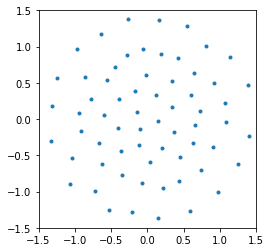

In [25]:
outPdBm = sess.run( PdBm )

np_constellation = sess.run(constellation)
plt.plot(np.real(np_constellation),np.imag(np_constellation),'.')
plt.axis('square')
lim_ = 1.5
plt.xlim(-lim_,lim_)
plt.ylim(-lim_,lim_)
plt.savefig('const.png')

In [26]:
import claude.models.NLIN as nlin
# System parameters
qamParam = nlin.defaultParameters()
qamParam.nSpans = ssfParam.nSpans

aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd = nlin.calcConstants(qamParam)
powerSweep = np.arange(-8, 4, 0.1)

# QAM
qam_constellation = np.squeeze(tx.qammod(param.M))
qamParam.kur, qamParam.kur3 = nlin.calcKur(qam_constellation)

qamEffSNR = powerSweep - nlin.calcNLIN(qamParam, powerSweep, aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd)

# learned constellation
aeNlinParam = qamParam
aeNlinParam.kur, aeNlinParam.kur3 = nlin.calcKur(np_constellation)

aeEffSNR = powerSweep - nlin.calcNLIN(aeNlinParam, powerSweep, aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd)

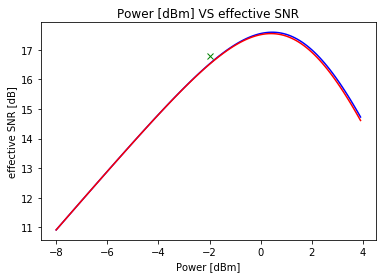

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(powerSweep, qamEffSNR, 'b')
plt.plot(powerSweep, aeEffSNR, 'r')
plt.plot(outPdBm, outMetrics['effSNR'], 'gx')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()
plt.savefig('snr.png')

In [28]:
qamMI = np.zeros(np.shape(qamEffSNR))
aeMI = np.zeros(np.shape(qamEffSNR))
N = 10000

for ii,p in enumerate(powerSweep):
    qamMI[ii] = cu.SNRtoMI(N, qamEffSNR[ii], np.expand_dims(qam_constellation, 0))
    aeMI[ii] = cu.SNRtoMI(N, aeEffSNR[ii], np.expand_dims(np_constellation, 0))

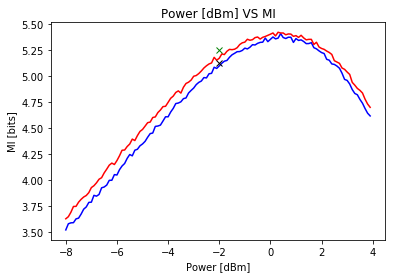

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(powerSweep, qamMI, 'b')
plt.plot(powerSweep, aeMI, 'r')
plt.plot(outPdBm, outMetrics['gaussMI'], 'gx')
plt.plot(outPdBm, outMetrics['nnMI'], 'kx')
plt.title('Power [dBm] VS MI')
plt.xlabel('Power [dBm]')
plt.ylabel('MI [bits]')
plt.show()
plt.savefig('mi.png')